# Final Project - ISGF3 and Antiproliferative Activities of Type I Interferons

Interferons are proteins that are secreted by cells in the immune system in response to the presence of pathogens. Specifically, Type I interferons (IFN) are released when cells recognizes a viral infection. By upregulating molecules that prevent viruses from replicating RNA and DNA, IFNs are able to increase host defenses, increasing antiviral, antiproliferative, and immunomodulatory activities. However, different IFNs exhibit different levels of these types of activities. 

In the [Jaks et al. paper](https://www.sciencedirect.com/science/article/pii/S0022283606015932?via%3Dihub), the authors concluded that different IFNs recruit signaling complexes with similar architectures, which likely cannot account for the differential signal activation. Therefore, the authors suggested that differences in IFN affinity towards the IFN receptor subunits, specifically ifnar-1 and ifnar-2, are the main reason for differential signal activation.

The goal of this exercise is to determine whether we can predict ISGF3 and antiproliferative activities using the rate and affinity constants provided by Jaks et al. In this analysis, Partial Least Squares Regression (PLSR) is applied on the rate and affinity constants to predict the ISGF3 and antiproliferative activities. Leave-One-Out Cross-Validation (LOOCV) will be used to generate an R2 value to evaluate how well the PLSR model performs.

### (0) Import all necessary libraries

In [1]:
# Import necessary libraries
% matplotlib inline
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
import pandas as pd
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model

### (1) Load and organize the data

The source of the data can be found in Table 1 of "Differential receptor subunit affinities of type I interferons govern differential signal activation" by Jaks et al.

In [2]:
# column indices
int_acts = ['k_a_2', 'k_d_2', 'K_d_2', 'k_a_1', 'k_d_1', 'K_d_1', 'ISGF3', 'antiproliferative', 'antiviral']

# row indices
IFN = ['IFNa1', 'IFNa2', 'IFNa8', 'IFNa21', 'IFNb', 'IFNw', 'IFNT2', 'E58A', 'R144A', 'E58A_R144A', 'ErrPercent']

data = pd.DataFrame(np.array([[2e6,  0.12,  100,  2e5,    0.5,   2.5,  47,   2,     400],
                            [3e6,  0.015, 5,    2e5,    1,     5.0,  8,    1.1,   40],
                            [6e6,  0.02,  3,    2e5,    0.5,   2.2,  5,    1.1,   20],
                            [3e6,  0.08,  25,   2e5,    0.5,   2.5,  20,   1.5,   50],
                            [1e7,  0.001, 0.1,  2e5,    0.025, 0.05, 1.5,  0.065, np.nan],
                            [6e6,  0.008, 1,    2e5,    0.08,  0.40, 3,    0.2,   np.nan],
                            [5e5,  0.8,   1200, 2e5,    2,     10.0, 3800, 60,    4000],
                            [3e6,  0.015, 5,    2e5,    0.1,   0.5,  2,    0.14,  np.nan],
                            [5e5,  0.05,  150,  2e5,    1,     5.0,  575,  10.0,  np.nan],
                            [5e5,  0.05,  150,  2e5,    0.1,   0.5,  390,  3.2,   np.nan],
                            [0.20, 0.10,  0.20, np.nan, 0.40,  0.30, 0.20, 0.30,  0.30]]))
data.columns = int_acts
data.index = IFN
data

,k_a_2,k_d_2,K_d_2,k_a_1,k_d_1,K_d_1,ISGF3,antiproliferative,antiviral
IFNa1,2000000.0,0.120,100.0,200000.0,0.500,2.50,47.0,2.000,400.0
IFNa2,3000000.0,0.015,5.0,200000.0,1.000,5.00,8.0,1.100,40.0
IFNa8,6000000.0,0.020,3.0,200000.0,0.500,2.20,5.0,1.100,20.0
IFNa21,3000000.0,0.080,25.0,200000.0,0.500,2.50,20.0,1.500,50.0
IFNb,10000000.0,0.001,0.1,200000.0,0.025,0.05,1.5,0.065,NaN
IFNw,6000000.0,0.008,1.0,200000.0,0.080,0.40,3.0,0.200,NaN
IFNT2,500000.0,0.800,1200.0,200000.0,2.000,10.00,3800.0,60.000,4000.0
E58A,3000000.0,0.015,5.0,200000.0,0.100,0.50,2.0,0.140,NaN
R144A,500000.0,0.050,150.0,200000.0,1.000,5.00,575.0,10.000,NaN
E58A_R144A,500000.0,0.050,150.0,200000.0,0.100,0.50,390.0,3.200,NaN


In order to perform future analyses, the data needs to be organized.

In [3]:
# ifn_data contains only the rate and affinity constants
ifn_data = data.drop(['ISGF3', 'antiproliferative', 'antiviral'], axis=1)
ifn_data = ifn_data.drop('ErrPercent', axis=0)
ifn_data = ifn_data.drop('k_a_1', axis = 1) # k_a_1 has the same value, causes problems when z-scoring, so remove from data

# ifn_zscored contains the data to be trained on
ifn_zscored = sp.stats.zscore(ifn_data)

# ISGF3_obs contains the observed ISGF3 levels
ISGF3_obs = data['ISGF3'].drop('ErrPercent', axis=0)

# antiprol_obs contains the observed antiproliferative levels
antiprol_obs = data['antiproliferative'].drop('ErrPercent', axis=0)

# antiviral_obs, from figures
antiviral_obs = pd.DataFrame([1140, 75.5, 18, 100, 10, 40, 11700])
antiviral_obs.index = IFN[0:7]
antiviral_obs = antiviral_obs[0]

### (2) Reimplementation

#### 2a. Compare the dissociation rate constants and equilibrium dissociation constants of different IFNs to immobilized ifnar2-EC.
This should correspond with [Figures 1g and 1h in the Jaks et al. paper](https://www.sciencedirect.com/science/article/pii/S0022283606015932?via%3Dihub#fig1), respectively.

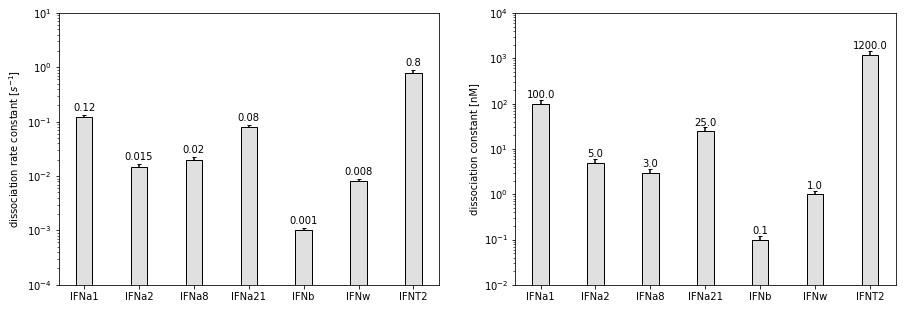

In [4]:
f = plt.figure(figsize=(15, 5))

# Plot Figure 1g
plt.subplot(121)
x = np.linspace(0,6,7)
plt.bar(x, ifn_data['k_d_2'][0:7], width=0.3, align='center', color='#e0e0e0', edgecolor='k')
plt.errorbar(x, ifn_data['k_d_2'][0:7], ls='none', color='k', capsize=2, yerr=[np.zeros(7), np.array(ifn_data['k_d_2'][0:7]*data['k_d_2']['ErrPercent'])])
for i in range(0, len(x)):
    plt.text(i, ifn_data['k_d_2'][i]*(1+10**-0.5), ifn_data['k_d_2'][i], horizontalalignment='center')
pylab.gca().set_yscale('log')
plt.ylim([10e-5,10e0])
plt.ylabel('dissociation rate constant [$s^{-1}$]')
plt.xticks(x, IFN[0:7])

# Plot Figure 1h
plt.subplot(122)
x = np.linspace(0,6,7)
plt.bar(x, ifn_data['K_d_2'][0:7], width=0.3, align='center', color='#e0e0e0', edgecolor='k')
plt.errorbar(x, ifn_data['K_d_2'][0:7], ls='none', color='k', capsize=2, yerr=[np.zeros(7), np.array(ifn_data['K_d_2'][0:7]*data['K_d_2']['ErrPercent'])])
for i in range(0, len(x)):
    plt.text(i, ifn_data['K_d_2'][i]*(1+10**-0.5), ifn_data['K_d_2'][i], horizontalalignment='center')
pylab.gca().set_yscale('log')
plt.ylim([10e-3,10e3])
plt.ylabel('dissociation constant [nM]')
plt.xticks(x, IFN[0:7]);

#### 2b. Compare the equilibrium dissociation constants and dissociation rate constants of different IFNs to immobilized ifnar1-EC.
This should correspond with [Figures 2e and 2f in the Jaks et al. paper](https://www.sciencedirect.com/science/article/pii/S0022283606015932?via%3Dihub#fig2), respectively.

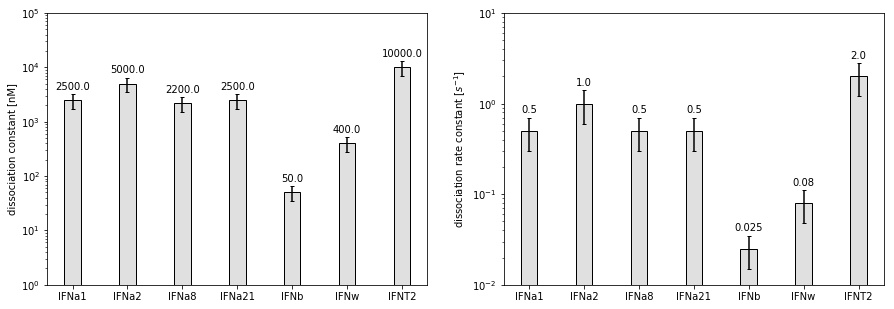

In [5]:
f = plt.figure(figsize=(15, 5))

# Plot Figure 2e
plt.subplot(121)
x = np.linspace(0,6,7)
plt.bar(x, 1000*ifn_data['K_d_1'][0:7], width=0.3, align='center', color='#e0e0e0', edgecolor='k')
plt.errorbar(x, 1000*ifn_data['K_d_1'][0:7], ls='none', color='k', capsize=2, yerr=1000*np.array(ifn_data['K_d_1'][0:7]*data['K_d_1']['ErrPercent']))
for i in range(0, len(x)):
    plt.text(i, 1000*ifn_data['K_d_1'][i]*(1+10**-.25), 1000*ifn_data['K_d_1'][i], horizontalalignment='center')
pylab.gca().set_yscale('log')
plt.ylim([10e-1,10e4])
plt.ylabel('dissociation constant [nM]')
plt.xticks(x, IFN[0:7])

# Plot Figure 2f
plt.subplot(122)
x = np.linspace(0,6,7)
plt.bar(x, ifn_data['k_d_1'][0:7], width=0.3, align='center', color='#e0e0e0', edgecolor='k')
plt.errorbar(x, ifn_data['k_d_1'][0:7], ls='none', color='k', capsize=2, yerr=np.array(ifn_data['k_d_1'][0:7]*data['k_d_1']['ErrPercent']))
for i in range(0, len(x)):
    plt.text(i, ifn_data['k_d_1'][i]*(1+10**-0.25), ifn_data['k_d_1'][i], horizontalalignment='center')
pylab.gca().set_yscale('log')
plt.ylim([10e-3,10e0])
plt.ylabel('dissociation rate constant [$s^{-1}$]')
plt.xticks(x, IFN[0:7]);

#### 2c. Compare the cellular activities of different type I IFNs.
This should correspond with [Figures 5c, 5d, 5e, and 5f in the Jaks et al. paper](https://www.sciencedirect.com/science/article/pii/S0022283606015932?via%3Dihub#fig5), respectively.

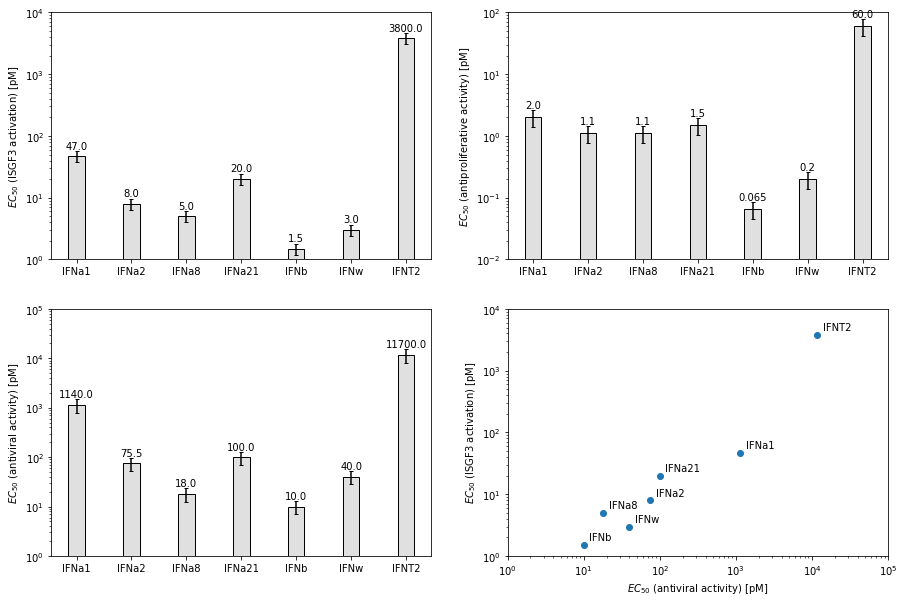

In [6]:
f = plt.figure(figsize=(15, 10))

# Plot Figure 5c
plt.subplot(221)
x = np.linspace(0,6,7)
plt.bar(x, ISGF3_obs[0:7], width=0.3, align='center', color='#e0e0e0', edgecolor='k')
plt.errorbar(x, ISGF3_obs[0:7], ls='none', color='k', capsize=2, yerr=np.array(ISGF3_obs[0:7]*data['ISGF3']['ErrPercent']))
for i in range(0, len(x)):
    plt.text(i, ISGF3_obs[i]*(1+10**-0.5), ISGF3_obs[i], horizontalalignment='center')
pylab.gca().set_yscale('log')
plt.ylim([10e-1,10e3])
plt.ylabel('$EC_{50}$ (ISGF3 activation) [pM]')
plt.xticks(x, IFN[0:7]);

# Plot Figure 5d
plt.subplot(222)
x = np.linspace(0,6,7)
plt.bar(x, antiprol_obs[0:7], width=0.3, align='center', color='#e0e0e0', edgecolor='k')
plt.errorbar(x, antiprol_obs[0:7], ls='none', color='k', capsize=2, yerr=np.array(antiprol_obs[0:7]*data['antiproliferative']['ErrPercent']))
for i in range(0, len(x)):
    plt.text(i, antiprol_obs[i]*(1+10**-0.4), antiprol_obs[i], horizontalalignment='center')
pylab.gca().set_yscale('log')
plt.ylim([10e-3,10e1])
plt.ylabel('$EC_{50}$ (antiproliferative activity) [pM]')
plt.xticks(x, IFN[0:7]);

# Plot Figure 5e
plt.subplot(223)
antiviral_obs = pd.DataFrame([1140, 75.5, 18, 100, 10, 40, 11700])
antiviral_obs.index = IFN[0:7]
antiviral_obs = antiviral_obs[0]
x = np.linspace(0,6,7)
plt.bar(x, antiviral_obs[0:7], width=0.3, align='center', color='#e0e0e0', edgecolor='k')
plt.errorbar(x, antiviral_obs[0:7], ls='none', color='k', capsize=2, yerr=np.array(antiviral_obs[0:7]*data['antiviral']['ErrPercent']))
for i in range(0, len(x)):
    plt.text(i, antiviral_obs[i]*(1+10**-0.4), antiviral_obs[i], horizontalalignment='center')
pylab.gca().set_yscale('log')
plt.ylim([10e-1,10e4])
plt.ylabel('$EC_{50}$ (antiviral activity) [pM]')
plt.xticks(x, IFN[0:7]);

# Plot Figure 5f
plt.subplot(224)
plt.scatter(antiviral_obs[0:7], ISGF3_obs[0:7])
for i in range(0, len(x)):
    plt.text(antiviral_obs[i]*(1+10**-.75), ISGF3_obs[i]*(1+10**-.75), IFN[i])
pylab.gca().set_xscale('log')
pylab.gca().set_yscale('log')
plt.xlim([10e-1,10e4])
plt.ylim([10e-1, 10e3])
plt.xlabel('$EC_{50}$ (antiviral activity) [pM]')
plt.ylabel('$EC_{50}$ (ISGF3 activation) [pM]');

#### 2d. Visualize correlation between affinities and activities.
This should correspond with [Figures 6a, 6b, 6c, and 6d in the Jaks et al. paper](https://www.sciencedirect.com/science/article/pii/S0022283606015932?via%3Dihub#fig6), respectively.

In [7]:
# Calculate relative potencies and relative binding affinities first, as described in the methods section

# relative potencies
p_rel_ISGF3 = 1/(ISGF3_obs)*ISGF3_obs['IFNa2']
p_rel_AP = 1/(antiprol_obs)*antiprol_obs['IFNa2']
p_diff_AP = p_rel_AP/p_rel_ISGF3
p_rel_AV = 1/(antiviral_obs)*antiviral_obs['IFNa2']

# relative binding affinities
K_rel_ifnar1 = ifn_data['K_d_1']['IFNa2']*(1/ifn_data['K_d_1'])
K_rel_ifnar2 = ifn_data['K_d_2']['IFNa2']*(1/ifn_data['K_d_2'])
K_rel_R1R2 = (((ifn_data['K_d_1']) / (ifn_data['K_d_2']))**-0.5)/((ifn_data['K_d_1']['IFNa2']/ifn_data['K_d_2']['IFNa2'])**-0.5)

# create new data set with the relative potencies and binding affinities
ifn_data_new = pd.DataFrame([])
ifn_data_new['p_rel_ISGF3'] = p_rel_ISGF3
ifn_data_new['p_rel_AP'] = p_rel_AP
ifn_data_new['p_diff_AP'] = p_diff_AP
#ifn_data_new['p_rel_AV'] = p_rel_AV
ifn_data_new['K_rel_ifnar1'] = K_rel_ifnar1
ifn_data_new['K_rel_ifnar2'] = K_rel_ifnar2
ifn_data_new['K_rel_R1R2'] = K_rel_R1R2
ifn_data_new = ifn_data_new.join(ifn_data)

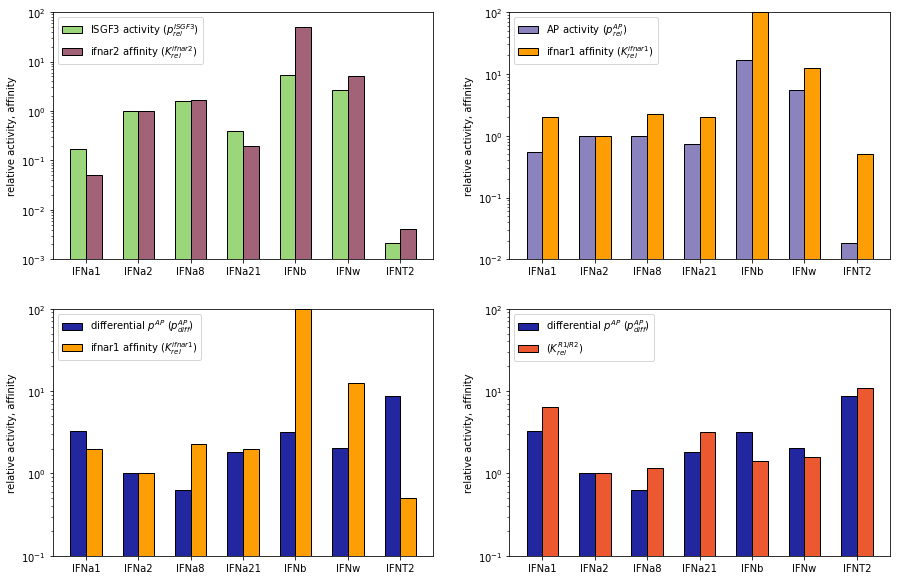

In [8]:
f = plt.figure(figsize=(15, 10))

# Plot Figure 6a
plt.subplot(221)
x = np.linspace(0,6,7)
w = 0.3
plt.bar(x-w/2, p_rel_ISGF3[0:7], width=w, color='#9BD67A', edgecolor='k')
plt.bar(x+w/2, K_rel_ifnar2[0:7], width=w, color='#A26378', edgecolor='k')
plt.legend(['ISGF3 activity ($p_{rel}^{ISGF3}$)', 'ifnar2 affinity ($K_{rel}^{ifnar2}$)'])
pylab.gca().set_yscale('log')
plt.ylim([10e-4,10e1])
plt.ylabel('relative activity, affinity')
plt.xticks(x, IFN[0:7])

# Plot Figure 6b
plt.subplot(222)
x = np.linspace(0,6,7)
w = 0.3
plt.bar(x-w/2, p_rel_AP[0:7], width=w, color='#8B83BE', edgecolor='k')
plt.bar(x+w/2, K_rel_ifnar1[0:7], width=w, color='#FD9E04', edgecolor='k')
plt.legend(['AP activity ($p_{rel}^{AP}$)', 'ifnar1 affinity ($K_{rel}^{ifnar1}$)'])
pylab.gca().set_yscale('log')
plt.ylim([10e-3,10e1])
plt.ylabel('relative activity, affinity')
plt.xticks(x, IFN[0:7])

# Plot Figure 6c
plt.subplot(223)
x = np.linspace(0,6,7)
w = 0.3
plt.bar(x-w/2, p_diff_AP[0:7], width=w, color='#22279F', edgecolor='k')
plt.bar(x+w/2, K_rel_ifnar1[0:7], width=w, color='#FD9E04', edgecolor='k')
plt.legend(['differential $p^{AP}$ ($p_{diff}^{AP}$)', 'ifnar1 affinity ($K_{rel}^{ifnar1}$)'])
pylab.gca().set_yscale('log')
plt.ylim([10e-2,10e1])
plt.ylabel('relative activity, affinity')
plt.xticks(x, IFN[0:7])

# Plot Figure 6d
plt.subplot(224)
x = np.linspace(0,6,7)
w = 0.3
plt.bar(x-w/2, p_diff_AP[0:7], width=w, color='#22279F', edgecolor='k')
plt.bar(x+w/2, K_rel_R1R2[0:7], width=w, color='#EC5830', edgecolor='k')
plt.legend(['differential $p^{AP}$ ($p_{diff}^{AP}$)', '($K_{rel}^{R1/R2}$)'], loc=2)
pylab.gca().set_yscale('log')
plt.ylim([10e-2,10e1])
plt.ylabel('relative activity, affinity')
plt.xticks(x, IFN[0:7]);

#### 2e. Visualize correlation between affinities and activities of wild-type and mutant IFNs.
This should correspond with [Figures 7a, 7b, and 7c in the Jaks et al. paper](https://www.sciencedirect.com/science/article/pii/S0022283606015932?via%3Dihub#fig7), respectively.

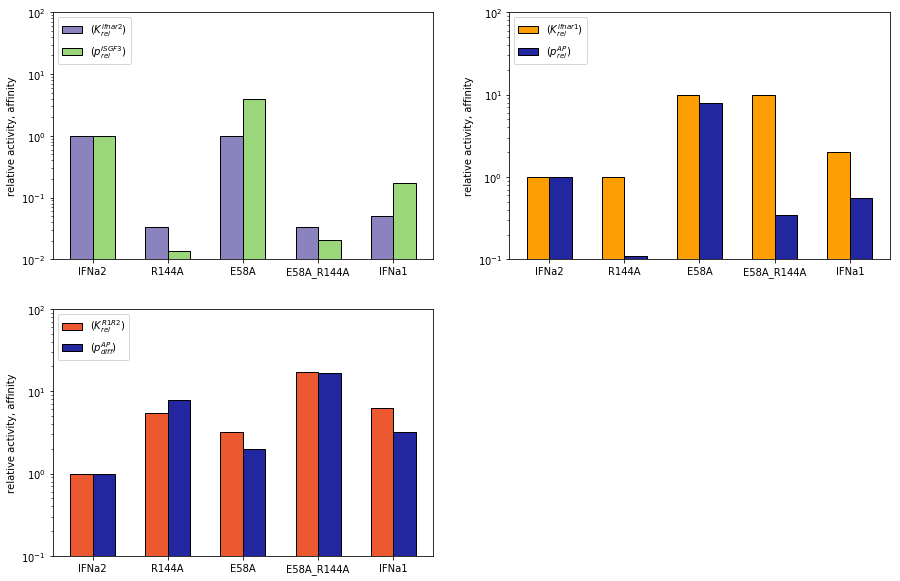

In [9]:
f = plt.figure(figsize=(15, 10))

# wild-type and mutant indices
mut = [1, 8, 7, 9, 0]

# Plot Figure 7a
plt.subplot(221)
x = np.linspace(0,4,5)
w = 0.3
plt.bar(x-w/2, K_rel_ifnar2[mut], width=w, color='#8B83BE', edgecolor='k')
plt.bar(x+w/2, p_rel_ISGF3[mut], width=w, color='#9BD67A', edgecolor='k')
plt.legend(['($K_{rel}^{ifnar2}$)', '($p_{rel}^{ISGF3}$)'], loc=2)
pylab.gca().set_yscale('log')
plt.ylim([10e-3,10e1])
plt.ylabel('relative activity, affinity')
plt.xticks(x, np.array(IFN)[mut]);

# Plot Figure 7b
plt.subplot(222)
x = np.linspace(0,4,5)
w = 0.3
plt.bar(x-w/2, K_rel_ifnar1[mut], width=w, color='#FD9E04', edgecolor='k')
plt.bar(x+w/2, p_rel_AP[mut], width=w, color='#22279F', edgecolor='k')
plt.legend(['($K_{rel}^{ifnar1}$)', '($p_{rel}^{AP}$)'], loc=2)
pylab.gca().set_yscale('log')
plt.ylim([10e-2,10e1])
plt.ylabel('relative activity, affinity')
plt.xticks(x, np.array(IFN)[mut]);

# Plot Figure 7c
plt.subplot(223)
x = np.linspace(0,4,5)
w = 0.3
plt.bar(x-w/2, K_rel_R1R2[mut], width=w, color='#EC5830', edgecolor='k')
plt.bar(x+w/2, p_diff_AP[mut], width=w, color='#22279F', edgecolor='k')
plt.legend(['($K_{rel}^{R1R2}$)', '($p_{diff}^{AP}$)'], loc=2)
pylab.gca().set_yscale('log')
plt.ylim([10e-2,10e1])
plt.ylabel('relative activity, affinity')
plt.xticks(x, np.array(IFN)[mut]);

### (3) Apply PCA to identify clusters, if present

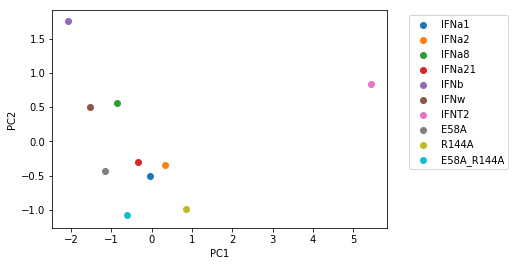

In [10]:
# Create PCA instance
pca = PCA()

# Scale the data
ifn_scaled = scale(ifn_data)

# Fit the data
ifn_PCs = pca.fit_transform(ifn_scaled)

# Plot the data
for i in range(0, ifn_PCs.shape[0]):
    plt.scatter(ifn_PCs[i,0], ifn_PCs[i,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(IFN[0:10], bbox_to_anchor=(1.05, 1))

Clusters cannot be visually distinguished.

### (4) Determine the ISGF3 activity of each IFN

#### 4a. Apply PLSR to predict the ISGF3 activity of each IFN using the given dataset

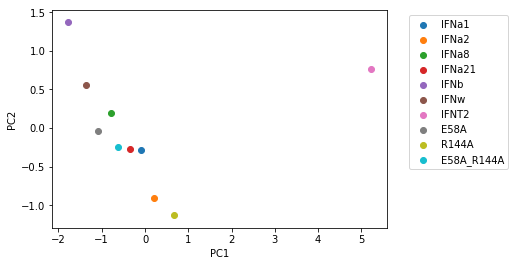

In [11]:
# Create instance of PLSR
PLS_I = PLSRegression(n_components=4, max_iter=1000)

# Fit the data
xSc_I, ySc_I = PLS_I.fit_transform(ifn_zscored, ISGF3_obs)

# Plot the result
for i in range(0, xSc_I.shape[0]):
    plt.scatter(xSc_I[i,0], xSc_I[i,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(IFN[0:10], loc='upper center', ncol = 3);
plt.legend(IFN[0:10], bbox_to_anchor=(1.05, 1))

#### 4b. Use LOOCV to evaluate PLSR performance

R2: 0.861779675287


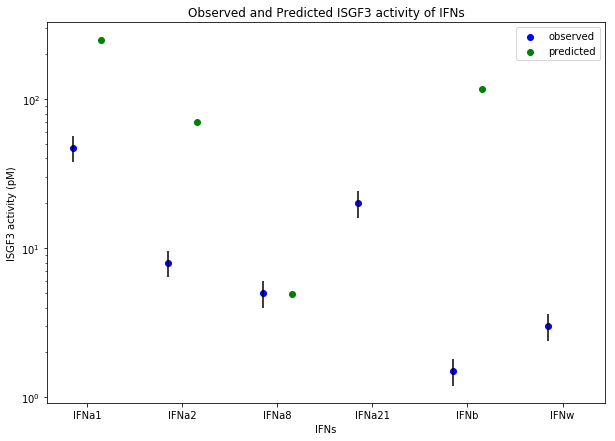

In [12]:
# Create instance of leave-one-out
loo_I = LeaveOneOut()
I_model_CV = np.zeros(len(ISGF3_obs))

# LOOCV
for train, test in loo_I.split(ISGF3_obs):
    # Split into training and testing data
    X_train = ifn_zscored[train]
    Y_train = ISGF3_obs[train]
    
    # Create instance of PLSR
    PLS_I_CV = PLSRegression(n_components=4, max_iter=1000)
    
    # Fit X_train and Y_train
    PLS_I_CV.fit_transform(X_train, Y_train)
    
    # Find the predicted antiproliferative
    I_model_CV[test] = PLS_I_CV.predict(ifn_zscored[test])

# Plot
x = np.linspace(0,5,6)
err = np.array(data['ISGF3']['ErrPercent']*ISGF3_obs)
w = 0.3
plt.figure(figsize=(10,7))
for i in x:
    plt.scatter(i-w/2, ISGF3_obs[int(i)], color = 'b')
    plt.errorbar(i-w/2, ISGF3_obs[int(i)], yerr = err[int(i)], color='k')
    plt.scatter(i+w/2, I_model_CV[int(i)], color = 'g')
plt.xticks(x, IFN[:-1])
plt.legend(['observed', 'predicted'])
plt.xlabel('IFNs')
plt.ylabel('ISGF3 activity (pM)')
plt.title('Observed and Predicted ISGF3 activity of IFNs');
pylab.gca().set_yscale('log')

# R2 score
print('R2:', r2_score(ISGF3_obs, I_model_CV))

In [13]:
# I_model contains predicted values
I_model = pd.DataFrame(I_model_CV)
I_model.index = IFN[:-1]
I_model.columns = ['Predicted ISGF3']

# obs_range contains the acceptable range that predicted values can be in based on observed value
I_obs_range=[]
for i in range(0, I_model.shape[0]):
    I_obs_range.append(str(ISGF3_obs[i] * (1-data['ISGF3']['ErrPercent'])) + ' - ' + str(ISGF3_obs[i] * (1+data['ISGF3']['ErrPercent'])))
I_obs_range = pd.DataFrame(I_obs_range)
I_obs_range.index = IFN[:-1]
I_obs_range.columns = ['Acceptable Range']

# I_results is a table that shows how well the PLSR model did
I_results = pd.concat([ISGF3_obs, I_obs_range, I_model], axis=1)
I_results['Prediction within range'] = np.where((I_results['Predicted ISGF3'] > I_results['ISGF3'] * (1-data['ISGF3']['ErrPercent'])) & (I_results['Predicted ISGF3'] < I_results['ISGF3'] * (1+data['ISGF3']['ErrPercent'])), True, False)
I_results

,ISGF3,Acceptable Range,Predicted ISGF3,Prediction within range
IFNa1,47.0,37.6 - 56.4,250.403051,False
IFNa2,8.0,6.4 - 9.6,70.638494,False
IFNa8,5.0,4.0 - 6.0,4.941827,True
IFNa21,20.0,16.0 - 24.0,-115.270477,False
IFNb,1.5,1.2 - 1.8,116.092758,False
IFNw,3.0,2.4 - 3.6,-43.410168,False
IFNT2,3800.0,3040.0 - 4560.0,2525.935296,False
E58A,2.0,1.6 - 2.4,-103.617038,False
R144A,575.0,460.0 - 690.0,506.222188,True
E58A_R144A,390.0,312.0 - 468.0,530.224506,False


### (5) Determine the Antiproliferative activity of each IFN

#### 5a. Apply PLSR to predict the Antiproliferative activity of each IFN

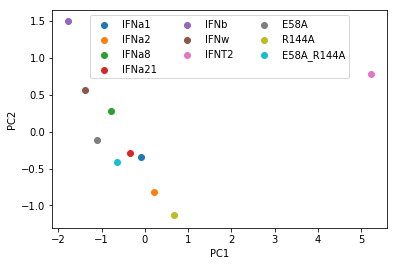

In [14]:
# Create instance of PLSR
PLS_A = PLSRegression(n_components=4, max_iter=1000)

# Fit the data
xSc_A, ySc_A = PLS_A.fit_transform(ifn_zscored, antiprol_obs)

# Plot the result
for i in range(0, xSc_A.shape[0]):
    plt.scatter(xSc_A[i,0], xSc_A[i,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(IFN[0:10], loc='upper center', ncol = 3);

#### 5b. Use LOOCV to evaluate PLSR performance

R2: 0.893976534486


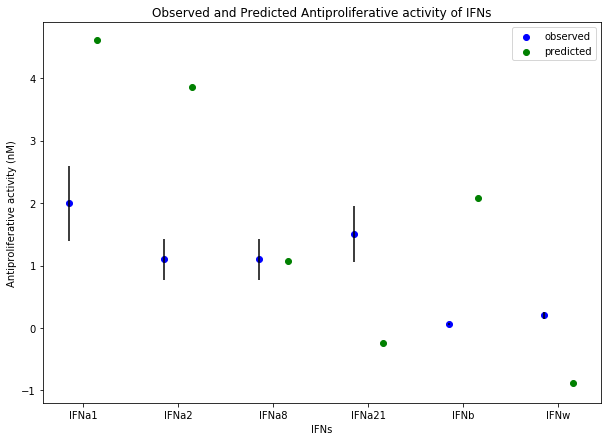

In [15]:
# Create instance of leave-one-out
loo_A = LeaveOneOut()
A_model_CV = np.zeros(len(antiprol_obs))

# LOOCV
for train, test in loo_A.split(antiprol_obs):
    # Split into training and testing data
    X_train = ifn_zscored[train]
    Y_train = antiprol_obs[train]
    
    # Create instance of PLSR
    PLS_A_CV = PLSRegression(n_components=4, max_iter=1000)
    
    # Fit X_train and Y_train
    PLS_A_CV.fit_transform(X_train, Y_train)
    
    # Find the predicted antiproliferative
    A_model_CV[test] = PLS_A_CV.predict(ifn_zscored[test])

# Plot
x = np.linspace(0,5,6)
err = np.array(data['antiproliferative']['ErrPercent']*antiprol_obs)
w = 0.3
plt.figure(figsize=(10,7))
for i in x:
    plt.scatter(i-w/2, antiprol_obs[int(i)], color = 'b')
    plt.errorbar(i-w/2, antiprol_obs[int(i)], yerr = err[int(i)], color='k')
    plt.scatter(i+w/2, A_model_CV[int(i)], color = 'g')
plt.xticks(x, IFN[:-1])
plt.legend(['observed', 'predicted'])
plt.xlabel('IFNs')
plt.ylabel('Antiproliferative activity (nM)')
plt.title('Observed and Predicted Antiproliferative activity of IFNs');

# R2 score
print('R2:', r2_score(antiprol_obs, A_model_CV))

In [16]:
# A_model contains predicted values
A_model = pd.DataFrame(A_model_CV)
A_model.index = IFN[:-1]
A_model.columns = ['Predicted antiproliferative']

# obs_range contains the acceptable range that predicted values can be in based on observed value
A_obs_range=[]
for i in range(0, A_model.shape[0]):
    A_obs_range.append(str(antiprol_obs[i] * (1-data['antiproliferative']['ErrPercent'])) + ' - ' + str(antiprol_obs[i] * (1+data['antiproliferative']['ErrPercent'])))
A_obs_range = pd.DataFrame(A_obs_range)
A_obs_range.index = IFN[:-1]
A_obs_range.columns = ['Acceptable Range']

# I_results is a table that shows how well the PLSR model did
A_results = pd.concat([antiprol_obs, A_obs_range, A_model], axis=1)
A_results['Prediction within range'] = np.where((A_results['Predicted antiproliferative'] > A_results['antiproliferative'] * (1-data['antiproliferative']['ErrPercent'])) & (A_results['Predicted antiproliferative'] < A_results['antiproliferative'] * (1+data['antiproliferative']['ErrPercent'])), True, False)
A_results

,antiproliferative,Acceptable Range,Predicted antiproliferative,Prediction within range
IFNa1,2.000,1.4 - 2.6,4.606070,False
IFNa2,1.100,0.77 - 1.43,3.851453,False
IFNa8,1.100,0.77 - 1.43,1.078108,True
IFNa21,1.500,1.05 - 1.95,-0.244630,False
IFNb,0.065,0.0455 - 0.0845,2.086526,False
IFNw,0.200,0.14 - 0.26,-0.878390,False
IFNT2,60.000,42.0 - 78.0,43.750093,True
E58A,0.140,0.098 - 0.182,-2.154072,False
R144A,10.000,7.0 - 13.0,6.642939,False
E58A_R144A,3.200,2.24 - 4.16,8.136540,False


#### (6) Jaks, et al. claims there are correlations between certain pairs of ratios and activities. Use Linear Regression to determine how accurately these ratios can predict activities.

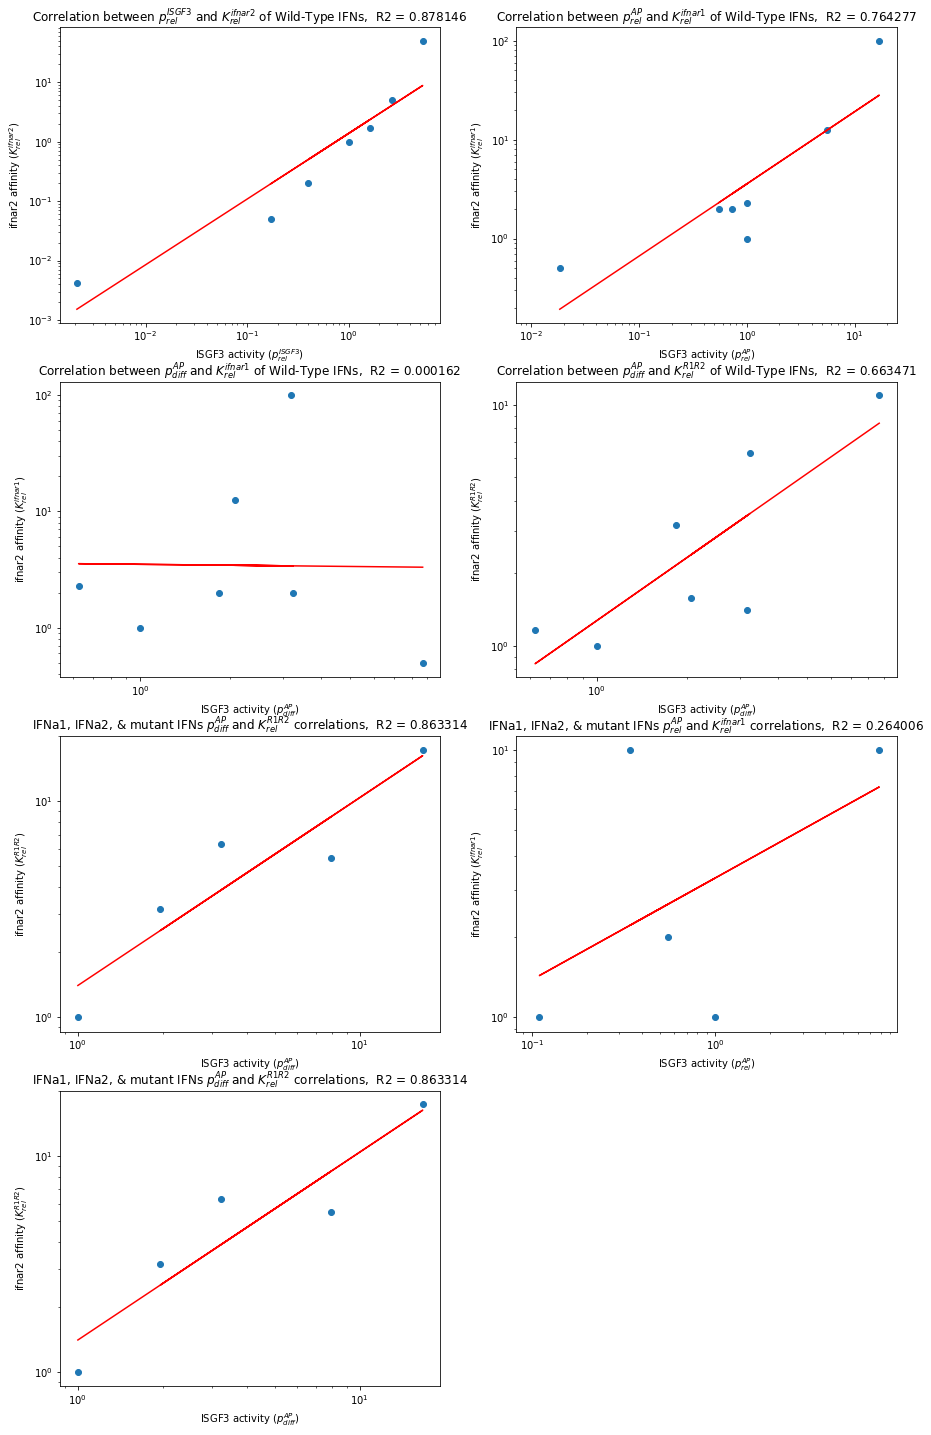

In [17]:
plt.figure(figsize=(15,25))

# LR on Figure 6a
plt.subplot(421)
X = ifn_data_new['p_rel_ISGF3'][0:7]
Y = ifn_data_new['K_rel_ifnar2'][0:7]
m, c = np.polyfit(np.log(X), np.log(Y), 1)
y_fit = np.exp(m*np.log(X) + c)
plt.scatter(X, Y)
plt.plot(X, y_fit, c='r')
pylab.gca().set_xscale('log')
pylab.gca().set_yscale('log')
plt.xlabel('ISGF3 activity ($p_{rel}^{ISGF3}$)')
plt.ylabel('ifnar2 affinity ($K_{rel}^{ifnar2}$)')
plt.title('Correlation between $p_{rel}^{ISGF3}$ and $K_{rel}^{ifnar2}$ of Wild-Type IFNs,  R2 = %f' % r2_score(np.log(Y), np.log(y_fit)))

# LR on Figure 6b
plt.subplot(422)
X = ifn_data_new['p_rel_AP'][0:7]
Y = ifn_data_new['K_rel_ifnar1'][0:7]
m, c = np.polyfit(np.log(X), np.log(Y), 1)
y_fit = np.exp(m*np.log(X) + c)
plt.scatter(X, Y)
plt.plot(X, y_fit, c='r')
pylab.gca().set_xscale('log')
pylab.gca().set_yscale('log')
plt.xlabel('ISGF3 activity ($p_{rel}^{AP}$)')
plt.ylabel('ifnar2 affinity ($K_{rel}^{ifnar1}$)')
plt.title('Correlation between $p_{rel}^{AP}$ and $K_{rel}^{ifnar1}$ of Wild-Type IFNs,  R2 = %f' % r2_score(np.log(Y), np.log(y_fit)))

# LR on Figure 6c
plt.subplot(423)
X = ifn_data_new['p_diff_AP'][0:7]
Y = ifn_data_new['K_rel_ifnar1'][0:7]
m, c = np.polyfit(np.log(X), np.log(Y), 1)
y_fit = np.exp(m*np.log(X) + c)
plt.scatter(X, Y)
plt.plot(X, y_fit, c='r')
pylab.gca().set_xscale('log')
pylab.gca().set_yscale('log')
plt.xlabel('ISGF3 activity ($p_{diff}^{AP}$)')
plt.ylabel('ifnar2 affinity ($K_{rel}^{ifnar1}$)')
plt.title('Correlation between $p_{diff}^{AP}$ and $K_{rel}^{ifnar1}$ of Wild-Type IFNs,  R2 = %f' % r2_score(np.log(Y), np.log(y_fit)))

# LR on Figure 6d
plt.subplot(424)
X = ifn_data_new['p_diff_AP'][0:7]
Y = ifn_data_new['K_rel_R1R2'][0:7]
m, c = np.polyfit(np.log(X), np.log(Y), 1)
y_fit = np.exp(m*np.log(X) + c)
plt.scatter(X, Y)
plt.plot(X, y_fit, c='r')
pylab.gca().set_xscale('log')
pylab.gca().set_yscale('log')
plt.xlabel('ISGF3 activity ($p_{diff}^{AP}$)')
plt.ylabel('ifnar2 affinity ($K_{rel}^{R1R2}$)')
plt.title('Correlation between $p_{diff}^{AP}$ and $K_{rel}^{R1R2}$ of Wild-Type IFNs,  R2 = %f' % r2_score(np.log(Y), np.log(y_fit)))

# LR on Figure 7a
plt.subplot(425)
X = ifn_data_new['p_diff_AP'][mut]
Y = ifn_data_new['K_rel_R1R2'][mut]
m, c = np.polyfit(np.log(X), np.log(Y), 1)
y_fit = np.exp(m*np.log(X) + c)
plt.scatter(X, Y)
plt.plot(X, y_fit, c='r')
pylab.gca().set_xscale('log')
pylab.gca().set_yscale('log')
plt.xlabel('ISGF3 activity ($p_{diff}^{AP}$)')
plt.ylabel('ifnar2 affinity ($K_{rel}^{R1R2}$)')
plt.title('IFNa1, IFNa2, & mutant IFNs $p_{diff}^{AP}$ and $K_{rel}^{R1R2}$ correlations,  R2 = %f' % r2_score(np.log(Y), np.log(y_fit)))

# LR on Figure 7b
plt.subplot(426)
X = ifn_data_new['p_rel_AP'][mut]
Y = ifn_data_new['K_rel_ifnar1'][mut]
m, c = np.polyfit(np.log(X), np.log(Y), 1)
y_fit = np.exp(m*np.log(X) + c)
plt.scatter(X, Y)
plt.plot(X, y_fit, c='r')
pylab.gca().set_xscale('log')
pylab.gca().set_yscale('log')
plt.xlabel('ISGF3 activity ($p_{rel}^{AP}$)')
plt.ylabel('ifnar2 affinity ($K_{rel}^{ifnar1}$)')
plt.title('IFNa1, IFNa2, & mutant IFNs $p_{rel}^{AP}$ and $K_{rel}^{ifnar1}$ correlations,  R2 = %f' % r2_score(np.log(Y), np.log(y_fit)))

# LR on Figure 7c
plt.subplot(427)
X = ifn_data_new['p_diff_AP'][mut]
Y = ifn_data_new['K_rel_R1R2'][mut]
m, c = np.polyfit(np.log(X), np.log(Y), 1)
y_fit = np.exp(m*np.log(X) + c)
plt.scatter(X, Y)
plt.plot(X, y_fit, c='r')
pylab.gca().set_xscale('log')
pylab.gca().set_yscale('log')
plt.xlabel('ISGF3 activity ($p_{diff}^{AP}$)')
plt.ylabel('ifnar2 affinity ($K_{rel}^{R1R2}$)')
plt.title('IFNa1, IFNa2, & mutant IFNs $p_{diff}^{AP}$ and $K_{rel}^{R1R2}$ correlations,  R2 = %f' % r2_score(np.log(Y), np.log(y_fit)));